<font size="5.5">**Functions used in the development of the project:**</font>
<br>
<br>
<font size="4.5">**Data Analytics in the Sports World: Assesing 2017/2018 English Premier League Data through Machine Learning**</font>

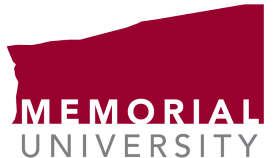

**Libraries**: Scikit-Learn was a great source of documentation for the development of this project. I deeply recommend the following book if you are looking to start in Machine Learning techniques: 
<br>
https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, ParameterGrid
from pandas.plotting import scatter_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, f1_score, make_scorer, roc_auc_score
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
import warnings
import random
from time import time
import seaborn as sns
import parfit.parfit as pf
import math
import json
from io import BytesIO
warnings.filterwarnings("ignore")
import json
from io import BytesIO
import networkx as nx
from mplsoccer.pitch import Pitch

Used in **WyScout Dataset - Exploration**

In [2]:
# To include nested lists ( must be flattened) and other columns apart
# load data using Python JSON module

#creating function to read unicode with "tildes". 
def read_json_file(filename):
    with open(filename,'rb') as json_file:
#for more info visit: https://docs.python.org/3/howto/unicode.html        
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

Used in **WyScout Dataset - Feature Processing**

In [3]:
def preprocess_features(X):
    ''' Preprocesses the football data and converts catagorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        # Collect the revised columns
        output = output.join(col_data)
    
    return output


def Level_Creation(Dataframe):
    ''' Arrangements for clean dataset creation at every level. '''
#inserting dataframe into the function to retrieve dummy variables
    Features_LevelX=preprocess_features(Dataframe)

#Adapting the data.
    Features_LevelX=Features_LevelX.drop('id',axis=1)

#Creating the y(target) columns. Outcome of the match. 
    Features_LevelX['Outcome']=np.where (Features_LevelX['winner']==Features_LevelX['teamId'],1,np.where(Features_LevelX['winner']==0,0,-1))

#Adapting the data.
    Features_LevelX=Features_LevelX.drop('winner',axis=1)
    Features_LevelX=Features_LevelX.groupby(['matchId','teamId','Outcome','Home_Away']).sum()
    Features_LevelX=Features_LevelX.reset_index()
    Features_LevelX=Features_LevelX.set_index(['matchId','teamId'])
#processed dataframe.
    return Features_LevelX    

Used in **WyScout Dataset - Model Selection (Train & Test)**

In [4]:
def Opposites_To(Dataframe):
    '''Creating opposition stats in the same row to compare team performance against rivals''' 
    Dataframe['matchId']=Dataframe['matchId'].fillna(method='ffill')
#Creating two temporary dataframes
    HT_First=Dataframe.sort_values(by=['matchId','Home_Away'],ascending=[True,False]).reset_index().drop(['matchId','index'],axis=1)
    AT_First=Dataframe.sort_values(by=['matchId','Home_Away'],ascending=[True,True]).reset_index().drop(['Outcome','Home_Away','index'],axis=1)
#Merging both dataframes to account for team and opposite team stats. 
    df=pd.merge(HT_First, AT_First, left_index=True, right_index=True)
    df['Outcome']=np.where(df['Outcome']==1,1,0)
    return df

def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = cross_val_predict(clf, features, target)
    
    end = time()
    # Print and return results
    #print "Made predictions in {:.4f} seconds.".format(end - start)
    
    return  f1_score(target, y_pred, average='weighted'), sum(target == y_pred) / float(len(y_pred))

#random matchweek options
Mweeks_Y=[0,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300,320,340,360,380,400,420,440,460,480,500,520,540,560,580,600,620,640]
Mweeks_Z=[100,200,300,400,500]

def Transformation_ByOrder (X, Origin, Border,Test):
    '''Transforms the dataset by normalizing their features and creating a pipeline. It also splits the dataset according to the
    desired margins of Origin and Border of analysis'''
#Standardizing values to be suitable for modelling using Simple Imputer and Standard Scaler. 
    Features=X.drop(['Outcome'],axis=1)
    Target=X['Outcome']
    
    #Creating Pipeline (Transforming dataframe for ML Algorithm)
    NumFeat=Features
    num_pipeline= Pipeline([('imputer',SimpleImputer(strategy='median')),('MinMax_scaler',MinMaxScaler()),])
    num_attribs=list(NumFeat)
    full_pipeline = ColumnTransformer([('num', num_pipeline, num_attribs)])
    Features_prepared= full_pipeline.fit_transform(Features)
   
    # Connecting column names with the standardized values from the pipeline
    numeric_features = Features.select_dtypes(np.number).columns
    labels = numeric_features


    #Creating transformed Dataframe.
    transformed_df = pd.DataFrame(full_pipeline.transform(Features), columns=labels)

    #merging together transformed dataset and Outcome. 
    Transformed=transformed_df.join(Target)
    


    #Dividing the data by index order 1 matchweek every 10 rows. 
    global List_Y, List_Z,List_W
    pass
    List_Y=random.choice(Origin)
    List_Z=random.choice(Border)
    List_W=random.choice(Test)

    while ((List_Y+List_Z+List_W)>760):
        try:
            List_Y=random.choice(Origin)
            List_Z=random.choice(Border)
            continue
        except:
            pass
    print('Start Matchweek: ',List_Y/20,'Final Matchweek: ',(List_Y+List_Z)/20)
    train_set = Transformed[List_Y:(List_Y+List_Z)]
    Limit= (List_Y+List_Z+List_W)
    test_set = Transformed[(List_Y+List_Z):Limit]
    
    
    #verifying correct stratification.
    #strat_train_set['teamId'].value_counts()/len(strat_train_set)
    #Dropping teamId again
    #for set_ in (train_set, test_set):
        #set_=set_.drop('teamId',axis=1,inplace=True)
    
    
    #Train and Test
    x_train, y_train= train_set.drop('Outcome',axis=1),train_set['Outcome']
    x_test, y_test= test_set.drop('Outcome',axis=1),test_set['Outcome']
    return x_train, y_train, x_test, y_test
    
    # Model Classifiers And regressors

def Modelling (x,y,xt,yt): 
    '''Takes a selection of classifier models and test them with f-1 score and accuracy measures each of them through iterations'''    
 #Addressing different models and showing accuracy and f1 scores results

    #Support Vector Machine
    ##Parameters
    modelSVC = SVC()
    Regularization = [0.1,1, 10, 100]
    shape = ['ovo','ovr']
    ##define grid search
    gridSVC = dict(C=Regularization,decision_function_shape=shape)
    cvSVC = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_searchSVC = GridSearchCV(estimator=modelSVC, param_grid=gridSVC, n_jobs=-1, cv=cvSVC, scoring='accuracy',error_score=0)
    svc_grid = grid_searchSVC.fit(x, y)
    ##get best fit
    svm_clf= svc_grid.best_estimator_

    #Stochastic Gradient Descend
    modelSGD=SGDClassifier(random_state=42)
    modelSGD.fit(x,y)
    ##Parameters
    loss_ = ['hinge','squared_hinge', 'perceptron']
    penalty_= ['l1','elasticnet']
    random =[42,20,None]
    ##define grid search
    gridSGD = dict(loss=loss_,penalty=penalty_, random_state=random)
    cvSGD = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_searchSGD= GridSearchCV(estimator=modelSGD, param_grid=gridSGD, n_jobs=-1, cv=cvSGD, scoring='accuracy',error_score=0)
    sgd_grid = grid_searchSGD.fit(x, y)
    ##get best fit
    sgd_clf= sgd_grid.best_estimator_
    
   
    #Logistic Regression
    ##Parameters
    modelLR= LogisticRegression(multi_class='multinomial')
    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    penalty = ['l1','l2']
    c_values = [100, 10, 1.0, 0.1, 0.01]
    # define grid search
    grid = dict(solver=solvers,penalty=penalty,C=c_values)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=modelLR, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
    softmax_grid = grid_search.fit(x, y)
    #Parameters
    softmax_reg= softmax_grid.best_estimator_
    
    #Graphic Explanation for Decision Tree
    #fig=plt.figure(figsize=(25,20))
    #_ = tree.plot_tree(tree_clf, 
                  # feature_names=x_train.columns,  
                   #class_names=('Won','Draw','Loss'),
                   #filled=True)
    #Random Forest
    modelRF= RandomForestClassifier()
    estimators = [100, 10, 1000, 200]
    crit = ['gini','entropy']
    minsample = [8, 10, 5]
    # define grid search
    gridRF = dict(n_estimators=estimators,criterion=crit,min_samples_split=minsample)
    cvRF = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_searchRF = GridSearchCV(estimator=modelRF, param_grid=gridRF, n_jobs=-1, cv=cvRF, scoring='accuracy',error_score=0)
    RF_grid = grid_searchRF.fit(x, y)
    #Parameters
    Rf_clf= RF_grid.best_estimator_
    #XGBoost
    ##charging parameters
    
    
    parameters = {'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
              'n_estimators': [40,50],
              'max_depth': [2, 3, 4,None],
              'colsample_bytree': [0.2,0.3,0.5,0.6,0.8],
              'alpha': [1e-5]
             }
    ##initializing xgboost
    xgb_clf_first= xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.2,
                    max_depth = 3, alpha = 10, n_estimators = 10, eval_metric='mlogloss')
    ##creating a scorer for the model
    f1_scorer=make_scorer(f1_score, pos_label=1, average='weighted')
    ##Using Grid Search to optimize XGBoost
    grid_obj = GridSearchCV(xgb_clf_first, 
                           scoring=f1_scorer,
                           param_grid=parameters,
                           cv=5)
    grid_obj= grid_obj.fit(x,y, eval_metric='mlogloss')
    ##Obtaining best Estimator
    xgb_clf=grid_obj.best_estimator_
    
    ##Ensemble Method
    voting_clf = VotingClassifier(
    estimators=[ ('RForest',Rf_clf), ('XGB',xgb_clf)],
    voting='hard')
    voting_clf.fit(x, y)
    
    #Gathering results and comparing in the training set:
    f1XGB, accXGB=predict_labels(xgb_clf, x, y)
    f1Rf, accRf=predict_labels(Rf_clf, x, y)
    f1SGD, accSGD=predict_labels(sgd_clf, x, y)
    f1SVM, accSVM=predict_labels(svm_clf, x, y)
    f1Softmax, accSoftmax=predict_labels(softmax_reg, x, y)
    f1Voting, accVoting=predict_labels(voting_clf, x, y)
    Modellist=['XG Boost', 'Random Forest', 'SGD Classifier', 'SVM Classifier', 'Softmax Regression', 'Voting Classifier']
    f1list=[f1XGB,f1Rf,f1SGD,f1SVM,f1Softmax,f1Voting]
    fitlist=[xgb_clf, Rf_clf, sgd_clf, svm_clf, softmax_reg, voting_clf]
    acclist=[accXGB,accRf,accSGD,accSVM,accSoftmax, accVoting]
    Models_df_Train = pd.DataFrame(list(zip(fitlist,Modellist,f1list, acclist)),
                   columns =['Fit','Model', 'Training F1 Score', 'Training Accuracy'])
    #Gathering results and comparing in the test set:
    f1XGB, accXGB=predict_labels(xgb_clf, xt, yt)
    f1Rf, accRf=predict_labels(Rf_clf, xt, yt)
    f1SGD, accSGD=predict_labels(sgd_clf, xt, yt)
    f1SVM, accSVM=predict_labels(svm_clf, xt, yt)
    f1Softmax, accSoftmax=predict_labels(softmax_reg, xt, yt)
    f1Voting, accVoting=predict_labels(voting_clf, xt, yt)
    Modellist=['XG Boost', 'Random Forest', 'SGD Classifier', 'SVM Classifier', 'Softmax Regression', 'Voting Classifier']
    f1list=[f1XGB,f1Rf,f1SGD,f1SVM,f1Softmax,f1Voting]
    fitlist=[xgb_clf, Rf_clf, sgd_clf, svm_clf, softmax_reg, voting_clf]
    acclist=[accXGB,accRf,accSGD,accSVM,accSoftmax, accVoting]
    Models_df_Test = pd.DataFrame(list(zip(fitlist,Modellist,f1list, acclist)),
                   columns =['Fit','Model', 'Testing F1 Score', 'Testing Accuracy'])
    
    #Final dataset of results
    Model=pd.merge(Models_df_Train,Models_df_Test,on=['Fit','Model'],how='left')
    #Return the model, and the best classifier object. 
    return {'Results': Model, 'clf': Model[['Fit']][Model['Testing Accuracy'] == Model['Testing Accuracy'].max()],
           'Accuracy':Model[['Testing Accuracy']][Model['Testing Accuracy'] == Model['Testing Accuracy'].max()]}


def Feature_Selection(fit,importance, x_train, x_test, y_train, y_test):
    '''Creates an iteration by changing the # of features and evaluating the model with each set of features'''
    #feature importance
    feat_importances =pd.Series(importance, index=x_train.columns)
    index = 0
    Results_accuracy =[0]
    Results_F1 =[0]
    for index in range(1, len(feat_importances)):
        Results_accuracy.append(index)
        Results_F1.append(index)
        index=index+1


    n_features = x_train.shape[1]
    i=0
    while n_features > 0:
        data=np.power(feat_importances,2)
        dataSq=data.nlargest(n_features)
        Xtop=dataSq.index.tolist()
    
        x_train_new=x_train[Xtop]
        x_test_new=x_test[Xtop]

        Iterationclf=fit
        Iterationclf.fit(x_train_new,y_train)
        score=predict_labels(Iterationclf,x_test_new,y_test)
        Results_accuracy[i]=score[1]
        Results_F1[i]=score[0]
        i=i+1
        n_features= n_features-1

    N_features = x_train.shape[1]
    accuracy_features = [" "]
    while N_features>0:
        accuracy_features.append(str(N_features))
        N_features = N_features - 1
    accuracy_features=accuracy_features[1:]
    Accuracy_df = pd.DataFrame(list(zip(accuracy_features,Results_accuracy, Results_F1)),
                   columns =['top n_features', 'accuracy in test','F1 Score'])
    #Result=Accuracy_df[Accuracy_df['accuracy in test']==Accuracy_df['accuracy in test'].max()]
    return Accuracy_df


def Iteration_by_Matchweeks(Level_Dataset, Classifier,Importance,Iterations):
    '''Makes iterations for your classifier trying all set of features in model accuracy'''
    index=0
    Itdf=[]
    Start=[]
    Finish=[]
    for index in range (0,Iterations):
        Start.append(index)
        Finish.append(index)
    
        x_train, y_train, x_test, y_test=Transformation_ByOrder(Level_Dataset,Mweeks_Y,Mweeks_Z,[60])
        data=Feature_Selection(Classifier,Importance,x_train, x_test,y_train,y_test)
        Start[index]=List_Y/20
        Finish[index]=(List_Y+List_Z)/20
        Itdf.append(data)

        index=index+1
    
    
    
    Itdf = pd.concat(Itdf)
    Start_=Start.copy()
    Start_= [Start for Start in Start_ for _ in range(len(x_train.columns))]
    Finish_=Finish.copy()
    Finish_= [Finish for Finish in Finish_ for _ in range(len(x_train.columns))]
    Itdf['Start Matchweek']=Start_
    Itdf['Finish Matchweek']=Finish_
    return Itdf



**WyScout Dataset - Passing Networks**

In [4]:
def Match_Situations(Events_df):
    '''Creates a situation column that categorizes the match state according to the score''' 
#Temporary Home and Away Goal indicator
    Events_df['Home_Goal']=np.where((Events_df['Description']=='Goal')&(Events_df['Home_Away']==1),1,0)
    Events_df['Away_Goal']=np.where((Events_df['Description']=='Goal')&(Events_df['Home_Away']==0),1,0)

#Create counter for match score in real time.
    Events_df['Home_GoalCount']=Events_df.groupby(['matchId'])['Home_Goal'].cumsum()
    Events_df['Away_GoalCount']=Events_df.groupby(['matchId'])['Away_Goal'].cumsum()

#match situation according to goals, 
    Events_df['Situation']=np.where(Events_df['Home_GoalCount']==Events_df['Away_GoalCount'],'Game Tie',
                                np.where(Events_df['Home_GoalCount']>Events_df['Away_GoalCount'], 'Home Winning','Away Winning'))

#Get rid of temporary columns as counter is created
    Events_df=Events_df.drop(['Home_Goal','Away_Goal'],axis=1)
    
    return Events_df

def Feature_Training_Importance(Events_df):
    '''Holds the features importance of the features at Level 3 and saves them to be applied to every event.'''
    GameEvents=Events_df.groupby(['matchId','teamId'])['playerId'].count().reset_index().rename(columns={'playerId':'Events/game'})
    MergedEvents=pd.merge(Events_df,GameEvents,on=['matchId','teamId'],how='left')

    #Level 3 (Fixing match Id for accounting both teams in the match.)
    Level3=pd.read_excel('Level3.xlsx')
    Level3_df=Opposites_To(Level3)


    x_train3, y_train3, x_test3, y_test3=Transformation_ByOrder(Level3_df,[0],[380],[100])

    modelSGD=SGDClassifier(penalty='l1', random_state=42)
    modelSGD.fit(x_train3, y_train3)
    coefficients_=modelSGD.coef_[0]

    feat_importances =pd.Series(coefficients_, index=x_train3.columns)


    feat_importances=feat_importances.reset_index().rename(columns={'index':'Feature',0: 'Importance'})
    search=['x','Home']
    feat_importances=feat_importances[feat_importances[
        'Feature'].str.contains('')==feat_importances[
        'Feature'].str.contains('|'.join(search))]

    temp=feat_importances['Feature'][1:].str.split('_')
    feat_importances['subEventName']=temp.str[2]
    feat_importances['Description']=temp.str[3]
    feat_importances['subEventName'][1]='Home_Away'



    feat_importances=feat_importances[(feat_importances['subEventName']=='Home_Away')|
                                  (feat_importances['Description']=='Accurate')]
    feat_importances=feat_importances.drop(['Feature','Description'],axis=1)
    Home_Away=feat_importances[feat_importances['subEventName']=='Home_Away']['Importance'][1]
    
    MergedEvents=pd.merge(MergedEvents,feat_importances,on='subEventName',how='left')
    MergedEvents['Importance']=np.where(MergedEvents['Home_Away']==1, 
                                        Home_Away/MergedEvents['Events/game'] +MergedEvents['Importance'],
                                        MergedEvents['Importance'])
    return MergedEvents  

def Match_Graph_Network(Events_df, matchId, matchperiod='All', matchsituation='All', Weight='None'):
    '''takes a match event dataset and transform it into a graph'''
    
    
    Events_df=Events_df[Events_df['matchId']==matchId]
    
    
    if matchsituation=='All':
        Events_df=Events_df.copy()
    else:
        Events_df=Events_df[Events_df['Situation']==matchsituation]
        
    if matchperiod=='All':
        Events_df=Events_df.copy()
    else:
        Events_df=Events_df[Events_df['matchPeriod']==matchperiod]
      
    
    teamsxmatch=Events_df[['teamId','Home_Away']].drop_duplicates().reset_index().drop('index',axis=1)
    teamsxmatch=teamsxmatch.sort_values(by='Home_Away',ascending=False).reset_index()
    
    '''Take into account events such as 1. Pass: See if the pass is accurate and if the teamId of the receiving player 
    is the same as sender. 2. If a duel takes place in the next event, evaluate if the winner of the duel is a player
    with the same teamId as the sender.'''
    #Creating the receiver for the pass
    Events_df=Events_df.rename(columns={"playerId": "SenderId", "shortName": "Sender"})
    Events_df['Receiver']=np.where(((Events_df['eventName']=='Pass')|(Events_df['eventName']=='Free kick'))
                                   &(Events_df['Description']=='Accurate'),
                                   np.where(Events_df['eventName'].shift(-1)=='Duel',
                                            np.where((Events_df['teamId'].shift(-1)==Events_df['teamId'])&
                                                     (Events_df['eventSec'].shift(-1)-Events_df['eventSec']<45),
                                                     Events_df['Sender'].shift(-1),
                                                    np.where((Events_df['teamId'].shift(-2)==Events_df['teamId'])&
                                                     (Events_df['eventSec'].shift(-2)-Events_df['eventSec']<45),
                                                             Events_df['Sender'].shift(-2),
                                                    np.where((Events_df['teamId'].shift(-3)==Events_df['teamId'])&
                                                     (Events_df['eventSec'].shift(-3)-Events_df['eventSec']<45),
                                                             Events_df['Sender'].shift(-3),
                                                            np.where((Events_df['teamId'].shift(-4)==Events_df['teamId'])&
                                                     (Events_df['eventSec'].shift(-4)-Events_df['eventSec']<45),
                                                                     Events_df['Sender'].shift(-4),
                                                                     None)))),
                                            np.where(Events_df['teamId'].shift(-1)==Events_df['teamId'],
                                                     Events_df['Sender'].shift(-1),None)),
                                   None)

    #Also the ReceiverId. P.D: Some players changed teams during the season.

    Events_df['ReceiverId']=np.where(((Events_df['eventName']=='Pass')|(Events_df['eventName']=='Free kick'))
                                   &(Events_df['Description']=='Accurate'),
                                   np.where(Events_df['eventName'].shift(-1)=='Duel',
                                            np.where((Events_df['teamId'].shift(-1)==Events_df['teamId'])&
                                                     (Events_df['eventSec'].shift(-1)-Events_df['eventSec']<45),
                                                     Events_df['SenderId'].shift(-1),
                                                    np.where((Events_df['teamId'].shift(-2)==Events_df['teamId'])&
                                                     (Events_df['eventSec'].shift(-2)-Events_df['eventSec']<45),
                                                             Events_df['SenderId'].shift(-2),
                                                    np.where((Events_df['teamId'].shift(-3)==Events_df['teamId'])&
                                                     (Events_df['eventSec'].shift(-3)-Events_df['eventSec']<45),
                                                             Events_df['SenderId'].shift(-3),
                                                            np.where((Events_df['teamId'].shift(-4)==Events_df['teamId'])&
                                                     (Events_df['eventSec'].shift(-4)-Events_df['eventSec']<45),
                                                                     Events_df['SenderId'].shift(-4),
                                                                     None)))),
                                            np.where(Events_df['teamId'].shift(-1)==Events_df['teamId'],
                                                     Events_df['SenderId'].shift(-1),None)),
                                   None)


    #Last modifications. If receiver is same player, drop it from the column. 
    Events_df['Receiver']=np.where(Events_df['Receiver']==Events_df['Sender'],None,Events_df['Receiver'])
    Events_df['ReceiverId']=np.where(Events_df['ReceiverId']==Events_df['SenderId'],None,Events_df['ReceiverId'])
    
    Match_PassNetwork=Events_df[Events_df['Receiver'].notnull()]
    
    if Weight== 'None':
    
    
        G_Home=nx.from_pandas_edgelist(Match_PassNetwork[Match_PassNetwork['teamId']==teamsxmatch['teamId'][0]],
                                                     source='Sender', target='Receiver')
        G_Away=nx.from_pandas_edgelist(Match_PassNetwork[Match_PassNetwork['teamId']==teamsxmatch['teamId'][1]],
                                   source='Sender', target='Receiver')
    else:
        G_Home=nx.from_pandas_edgelist(Match_PassNetwork[Match_PassNetwork['teamId']==teamsxmatch['teamId'][0]],
                                                     source='Sender', target='Receiver', edge_attr=Weight)
        G_Away=nx.from_pandas_edgelist(Match_PassNetwork[Match_PassNetwork['teamId']==teamsxmatch['teamId'][1]],
                                   source='Sender', target='Receiver',edge_attr=Weight)
    
    return Match_PassNetwork,G_Home, G_Away

def Team_Graph_Network(Events_df, teamId,Players='All', matchperiod='All', At='Both',When='All',Gameweek_Origin=1,
                      Gameweek_End=38, Weight='None'):
    '''takes a match event dataset and transform it into a graph'''
    
        
        
    if At=='Both':
        Events_df=Events_df.copy()
    if At=='Home':
        Events_df=Events_df[Events_df['Home_Away']==1]
    if At=='Away':
        Events_df=Events_df[Events_df['Home_Away']==0]
    
    if When=='All':
        Events_df=Events_df.copy()
    if When=='Winning':
        Events_df=Events_df[((Events_df['Home_Away']==1)&(Events_df['Situation']=='Home Winning'))|
                            ((Events_df['Home_Away']==0)&(Events_df['Situation']=='Away Winning'))]
    if When=='Tie':
        Events_df=Events_df[((Events_df['Home_Away']==1)|(Events_df['Home_Away']==0))&
                             (Events_df['Situation']=='Game Tie')]
    if When=='Loosing':
        Events_df=Events_df[((Events_df['Home_Away']==0)&(Events_df['Situation']=='Home Winning'))|
                            ((Events_df['Home_Away']==1)&(Events_df['Situation']=='Away Winning'))]
    if matchperiod=='All':
        Events_df=Events_df.copy()
    else:
        Events_df=Events_df[Events_df['matchPeriod']==matchperiod]
      
    Events_df=Events_df[(Events_df['gameweek']>=Gameweek_Origin)&(Events_df['gameweek']<=Gameweek_End)]
    
    
    '''Take into account events such as 1. Pass: See if the pass is accurate and if the teamId of the receiving player 
    is the same as sender. 2. If a duel takes place in the next event, evaluate if the winner of the duel is a player
    with the same teamId as the sender.'''
        #Creating the receiver for the pass
    Events_df=Events_df.rename(columns={"playerId": "SenderId", "shortName": "Sender"})
    Events_df['Receiver']=np.where(((Events_df['eventName']=='Pass')|(Events_df['eventName']=='Free kick'))
                                   &(Events_df['Description']=='Accurate'),
                                   np.where(Events_df['eventName'].shift(-1)=='Duel',
                                            np.where((Events_df['teamId'].shift(-1)==Events_df['teamId'])&
                                                     (Events_df['eventSec'].shift(-1)-Events_df['eventSec']<45),
                                                     Events_df['Sender'].shift(-1),
                                                    np.where((Events_df['teamId'].shift(-2)==Events_df['teamId'])&
                                                     (Events_df['eventSec'].shift(-2)-Events_df['eventSec']<45),
                                                             Events_df['Sender'].shift(-2),
                                                    np.where((Events_df['teamId'].shift(-3)==Events_df['teamId'])&
                                                     (Events_df['eventSec'].shift(-3)-Events_df['eventSec']<45),
                                                             Events_df['Sender'].shift(-3),
                                                            np.where((Events_df['teamId'].shift(-4)==Events_df['teamId'])&
                                                     (Events_df['eventSec'].shift(-4)-Events_df['eventSec']<45),
                                                                     Events_df['Sender'].shift(-4),
                                                                     None)))),
                                            np.where(Events_df['teamId'].shift(-1)==Events_df['teamId'],
                                                     Events_df['Sender'].shift(-1),None)),
                                   None)

    #Also the ReceiverId. P.D: Some players changed teams during the season.

    Events_df['ReceiverId']=np.where(((Events_df['eventName']=='Pass')|(Events_df['eventName']=='Free kick'))
                                   &(Events_df['Description']=='Accurate'),
                                   np.where(Events_df['eventName'].shift(-1)=='Duel',
                                            np.where((Events_df['teamId'].shift(-1)==Events_df['teamId'])&
                                                     (Events_df['eventSec'].shift(-1)-Events_df['eventSec']<45),
                                                     Events_df['SenderId'].shift(-1),
                                                    np.where((Events_df['teamId'].shift(-2)==Events_df['teamId'])&
                                                     (Events_df['eventSec'].shift(-2)-Events_df['eventSec']<45),
                                                             Events_df['SenderId'].shift(-2),
                                                    np.where((Events_df['teamId'].shift(-3)==Events_df['teamId'])&
                                                     (Events_df['eventSec'].shift(-3)-Events_df['eventSec']<45),
                                                             Events_df['SenderId'].shift(-3),
                                                            np.where((Events_df['teamId'].shift(-4)==Events_df['teamId'])&
                                                     (Events_df['eventSec'].shift(-4)-Events_df['eventSec']<45),
                                                                     Events_df['SenderId'].shift(-4),
                                                                     None)))),
                                            np.where(Events_df['teamId'].shift(-1)==Events_df['teamId'],
                                                     Events_df['SenderId'].shift(-1),None)),
                                   None)


    #Last modifications. If receiver is same player, drop it from the column. 
    Events_df['Receiver']=np.where(Events_df['Receiver']==Events_df['Sender'],None,Events_df['Receiver'])
    Events_df['ReceiverId']=np.where(Events_df['ReceiverId']==Events_df['SenderId'],None,Events_df['ReceiverId'])
    
    Events_df=Events_df[(Events_df['Receiver'].notnull())&(Events_df['teamId']==teamId)]
    if Players!='All':
        if Players=='Top 11':
            P_Events=Events_df[['Position','Sender']].value_counts().reset_index().rename(columns={0:'events'})
            Goalkeeper=P_Events[P_Events['Position']=='Goalkeeper'].nlargest(1,'events')
            FieldPlayers=P_Events[P_Events['Position']!='Goalkeeper'].nlargest(10,'events')
            Events_df=Events_df[((Events_df['Sender'].isin(Goalkeeper['Sender']))|(Events_df['Sender'].isin(FieldPlayers['Sender'])))&
                            ((Events_df['Receiver'].isin(Goalkeeper['Sender']))|(Events_df['Receiver'].isin(FieldPlayers['Sender'])))]
    
    if Weight=='None':

        G_Team=nx.from_pandas_edgelist(Events_df,source='Sender', target='Receiver')
    else:
        G_Team=nx.from_pandas_edgelist(Events_df,source='Sender', target='Receiver', edge_attr=Weight)
    
    
    return Events_df,G_Team

def Plot_Pass_Graph_Network(Dataframe,G_1,G_2=None,Visual='1',Color_1='red',Color_2='blue', Weight_1='None', Weight_2='None',
                           ColorMap_1=plt.cm.BuPu, ColorMap_2=plt.cm.BuGn): 
    '''Plot the created graphs'''
    pitch= Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white', stripe=False)
    fig, ax = pitch.draw(figsize=(16.5,11),constrained_layout=True, tight_layout=False)
    
    teamsxmatch=Dataframe[['teamId','Home_Away']].drop_duplicates().reset_index().drop('index',axis=1)
    teamsxmatch=teamsxmatch.sort_values(by='Home_Away',ascending=False).reset_index()
    
    Match_1=Dataframe[Dataframe['teamId']==teamsxmatch['teamId'][0]]
    
    
    if G_2!=None:
        
        Match_2=Dataframe[Dataframe['teamId']==teamsxmatch['teamId'][1]]
        
        AggX2Start=Match_2.groupby(['Sender'])['start.x'].mean().reset_index()
        #.agg(lambda x: pd.Series.mode(x)[0]).reset_index() <----- in case you wan't to change mean for mode. 
        AggX2Finish=Match_2.groupby(['Receiver'])['finish.x'].mean().reset_index().rename(columns={'Receiver':'Sender'})
    
        AggY2Start=Match_2.groupby(['Sender'])['start.y'].mean().reset_index()
        AggY2Finish=Match_2.groupby(['Receiver'])['finish.y'].mean().reset_index().rename(columns={'Receiver':'Sender'})
    
        AggX2=pd.merge(AggX2Start,AggX2Finish,on='Sender',how='left')
        AggX2['Agg.x']=(AggX2['start.x']+AggX2['finish.x'])/2
    
        AggY2=pd.merge(AggY2Start,AggY2Finish,on='Sender',how='left')
        AggY2['Agg.y']=(AggY2['start.y']+AggY2['finish.y'])/2
    
        Coord2=pd.merge(AggX2,AggY2,on=['Sender'],how='left')
        
         #Away team
        pos2 = {}
        for n in G_2.nodes():
            i = Coord2[Coord2["Sender"] == n].index[0]
            pos2[n] = ((120-Coord2.loc[i, "Agg.x"]), (80-Coord2.loc[i, "Agg.y"]))
        
        #creating a dictionary with every node degree ( amount of edges)
        degree2 = dict(G_2.degree)
    
    AggX1Start=Match_1.groupby(['Sender'])['start.x'].mean().reset_index()
    #.agg(lambda x: pd.Series.mode(x)[0]).reset_index() <----- in case you wan't to change mean for mode. 
    AggX1Finish=Match_1.groupby(['Receiver'])['finish.x'].mean().reset_index().rename(columns={'Receiver':'Sender'})
    
    
    AggY1Start=Match_1.groupby(['Sender'])['start.y'].mean().reset_index()
    AggY1Finish=Match_1.groupby(['Receiver'])['finish.y'].mean().reset_index().rename(columns={'Receiver':'Sender'})

    
    AggX1=pd.merge(AggX1Start,AggX1Finish,on='Sender',how='left')
    AggX1['Agg.x']=(AggX1['start.x']+AggX1['finish.x'])/2
    
    AggY1=pd.merge(AggY1Start,AggY1Finish,on='Sender',how='left')
    AggY1['Agg.y']=(AggY1['start.y']+AggY1['finish.y'])/2
    
   
    
    
    Coord1=pd.merge(AggX1,AggY1,on=['Sender'],how='left')
    
    
    
    # Defining positions
    
    pos1 = {}
    for n in G_1.nodes():
        i = Coord1[Coord1["Sender"] == n].index[0]
        pos1[n] = (Coord1.loc[i, "Agg.x"], Coord1.loc[i, "Agg.y"])
    
    #creating a dictionary with every node degree ( amount of edges)
    degree1 = dict(G_1.degree)
    
    if (Weight_1=='None')&(Weight_2=='None'):
   
        if Visual=='Both':
        
        
            nx.draw(G_1, pos1, width=3, edge_cmap=ColorMap_1,edge_color='black', 
                    alpha=0.55,font_family='monospace', style="solid",ax=ax) 
            nx.draw_networkx_labels(G_1,pos1,alpha=1,font_size=8,font_weight='bold')    
            nx.draw_networkx_nodes(G_1,pos1, edgecolors=Color_1, alpha=1, node_color='white',
                                  node_size=[v * 200 for v in degree1.values()])
            
            nx.draw(G_2, pos2, width=3, edge_cmap=ColorMap_2,edge_color='black', 
                    alpha=0.55,font_family='monospace', style="solid",ax=ax)
            nx.draw_networkx_labels(G_2,pos2,alpha=1,font_size=8,font_weight='bold')  
            nx.draw_networkx_nodes(G_2,pos2, edgecolors=Color_2, alpha=1, node_color='white',
                                  node_size=[v * 200 for v in degree2.values()])
        
        if Visual=='1':
        
        
            nx.draw(G_1, pos1, width=3, edge_cmap=ColorMap_1,edge_color='black', 
                    alpha=0.55,font_family='monospace', style="solid",ax=ax) 
            nx.draw_networkx_labels(G_1,pos1,alpha=1,font_size=8,font_weight='bold')    
            nx.draw_networkx_nodes(G_1,pos1, edgecolors=Color_1, alpha=1, node_color='white',
                                  node_size=[v * 200 for v in degree1.values()]) 
        
        if Visual=='2':
        
        
            nx.draw(G_2, pos2, width=3, edge_cmap=ColorMap_2,edge_color='black', 
                    alpha=0.55,font_family='monospace', style="solid",ax=ax)
            nx.draw_networkx_labels(G_2,pos2,alpha=1,font_size=8,font_weight='bold')  
            nx.draw_networkx_nodes(G_2,pos2, edgecolors=Color_2, alpha=1, node_color='white',
                                  node_size=[v * 200 for v in degree2.values()])
    
    if (Weight_1!='None')&(Weight_2=='None'): 
        
        
        if Visual=='1':
        
        
            nx.draw(G_1, pos1, width=3, edge_cmap=ColorMap_1,edge_color=Weight_1, 
                    alpha=0.55,font_family='monospace', style="solid",ax=ax) 
            nx.draw_networkx_labels(G_1,pos1,alpha=1,font_size=8, font_weight='bold')
            nx.draw_networkx_nodes(G_1,pos1, edgecolors=Color_1, alpha=1, node_color='white',
                                  node_size=[v * 200 for v in degree1.values()])
    else:        
        if Visual=='Both':
        
        
            nx.draw(G_1, pos1, width=3, edge_cmap=ColorMap_1, edge_color=Weight_1, 
                    alpha=0.55,font_family='monospace', style="solid",ax=ax) 
            nx.draw_networkx_labels(G_1,pos1,alpha=1,font_size=8,font_weight='bold')
            nx.draw_networkx_nodes(G_1,pos1, edgecolors=Color_1, alpha=1, node_color='white',
                                  node_size=[v * 200 for v in degree1.values()])
            
            nx.draw(G_2, pos2, width=3, edge_cmap=ColorMap_2,edge_color=Weight_2, 
                    alpha=0.55,font_family='monospace', style="solid",ax=ax)
            nx.draw_networkx_labels(G_2,pos2,alpha=1,font_size=8,font_weight='bold')  
            nx.draw_networkx_nodes(G_2,pos2, edgecolors=Color_2, alpha=1, node_color='white',
                                  node_size=[v * 200 for v in degree2.values()])
        
        if Visual=='1':
        
        
            nx.draw(G_1, pos1, width=3, edge_cmap=ColorMap_1,edge_color=Weight_1, 
                    alpha=0.55,font_family='monospace', style="solid",ax=ax) 
            nx.draw_networkx_labels(G_1,pos1,alpha=1,font_size=8,font_weight='bold')    
            nx.draw_networkx_nodes(G_1,pos1, edgecolors=Color_1, alpha=1, node_color='white',
                                  node_size=[v * 200 for v in degree1.values()])
            
        if Visual=='2':
        
        
            nx.draw(G_2, pos2, width=3, edge_cmap=ColorMap_2, edge_color=Weight_2, 
                    alpha=0.55,font_family='monospace', style="solid",ax=ax)
            nx.draw_networkx_labels(G_2,pos2,alpha=1,font_size=8,font_weight='bold')
            nx.draw_networkx_nodes(G_2,pos2, edgecolors=Color_2, alpha=1, node_color='white',
                                  node_size=[v * 200 for v in degree2.values()])